In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [ ]:
BASE_DIR = '/content/UTKFace'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)
random.shuffle(image_filenames)

for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)
  img_components = image.split('_')
  age_label = int(img_components[0])
  gender_label = int(img_components[1])

  # Append the image_path, age_label, and gender_label
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 23708, Number of gender_labels: 23708, Number of image_paths: 23708


In [ ]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

image_path  age  gender
0  /content/UTKFace/35_1_0_20170117135118514.jpg....   35       1
1  /content/UTKFace/86_0_0_20170120225623186.jpg....   86       0
2  /content/UTKFace/81_0_0_20170117091321806.jpg....   81       0
3  /content/UTKFace/31_1_0_20170117133139911.jpg....   31       1
4  /content/UTKFace/29_0_1_20170116011143078.jpg....   29       0

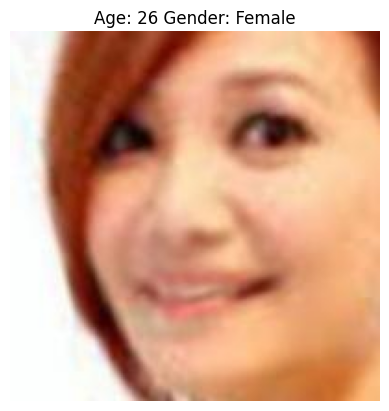

In [ ]:
from PIL import Image

rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

<Axes: xlabel='age', ylabel='Density'>

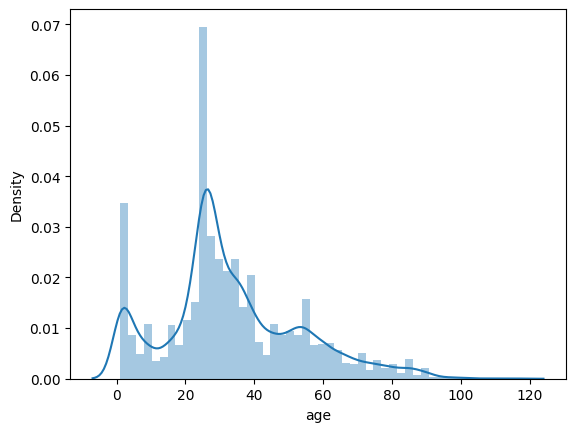

In [ ]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

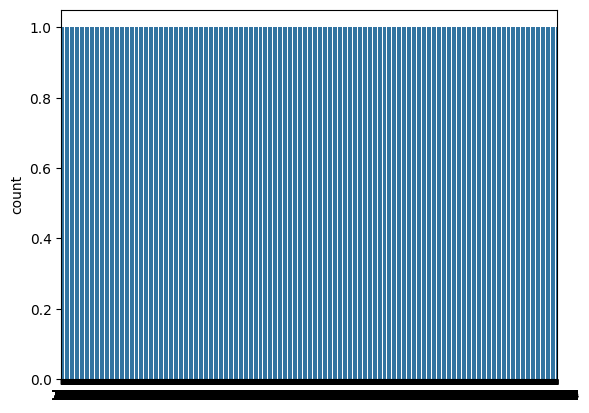

In [ ]:
sns.countplot(df['gender'])

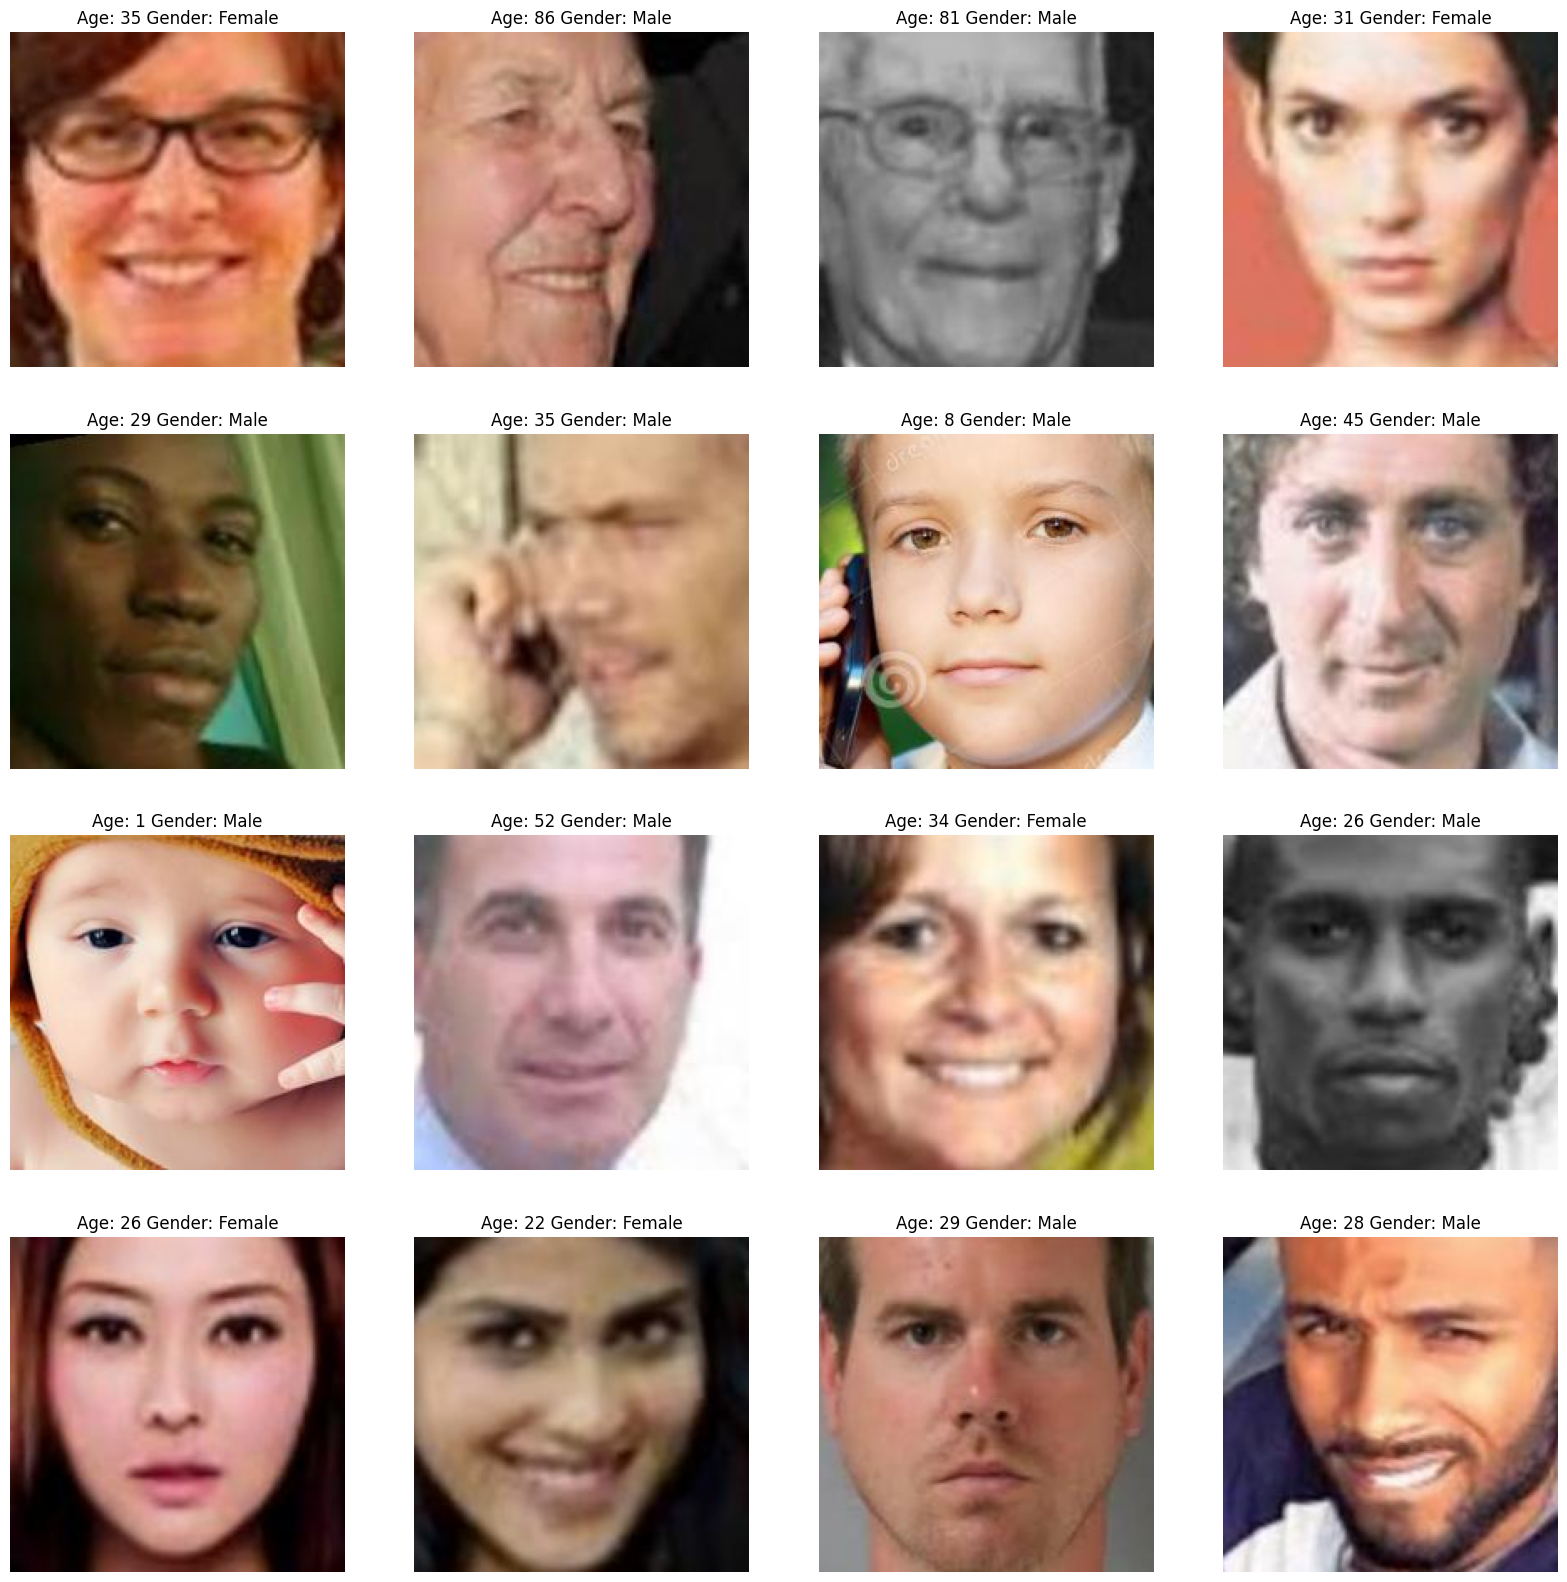

In [ ]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

In [ ]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')  # Corrected line
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
X = extract_image_features(df['image_path'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [ ]:
X.shape

(23708, 128, 128, 1)

In [ ]:
X = X / 255.0

In [ ]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization


# Define class weights to handle imbalance (adjust as per dataset distribution)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_gender), y=y_gender)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

input_shape = (128, 128, 1)

In [ ]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
conv_1 = BatchNormalization()(conv_1)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)

conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
conv_2 = BatchNormalization()(conv_2)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
conv_3 = BatchNormalization()(conv_3)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)

conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
conv_4 = BatchNormalization()(conv_4)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

# Use Focal Loss for better handling of imbalanced classes
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='linear', name='age_out')(dropout_2)  # Changed from relu to linear


model = Model(inputs=[inputs], outputs=[output_1, output_2])



In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

# Define Custom Focal Loss Function
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0) errors
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred) \
               - (1 - y_true) * (1 - alpha) * K.pow(y_pred, gamma) * K.log(1 - y_pred)
        return K.mean(loss)
    return loss

# Compile the Model with Custom Focal Loss
model.compile(loss=[focal_loss(alpha=0.25, gamma=2.0), 'mae'],
              optimizer=Adam(learning_rate=0.0001),
              metrics={'gender_out': 'accuracy', 'age_out': 'mae'})


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 33s 137ms/step - age_out_loss: 14.4140 - age_out_mae: 14.4138 - gender_out_accuracy: 0.6765 - gender_out_loss: 0.1882 - loss: 14.6020 - val_age_out_loss: 15.7638 - val_age_out_mae: 15.8548 - val_gender_out_accuracy: 0.5295 - val_gender_out_loss: 0.1552 - val_loss: 16.0082
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - age_out_loss: 8.3326 - age_out_mae: 8.3326 - gender_out_accuracy: 0.8002 - gender_out_loss: 0.0420 - loss: 8.3747 - val_age_out_loss: 17.7538 - val_age_out_mae: 17.7533 - val_gender_out_accuracy: 0.5295 - val_gender_out_loss: 0.0926 - val_loss: 17.8448
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - age_out_loss: 7.1703 - age_out_mae: 7.1704 - gender_out_accuracy: 0.8399 - gender_out_loss: 0.0336 - loss: 7.2040 - val_age_out_loss: 11.4752 - val_age_out_mae: 11.4778 - val_gender_out_accuracy: 0.6092 - val_gender_out_loss: 0.0630 - val_loss: 11.5406
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - age_out_loss:

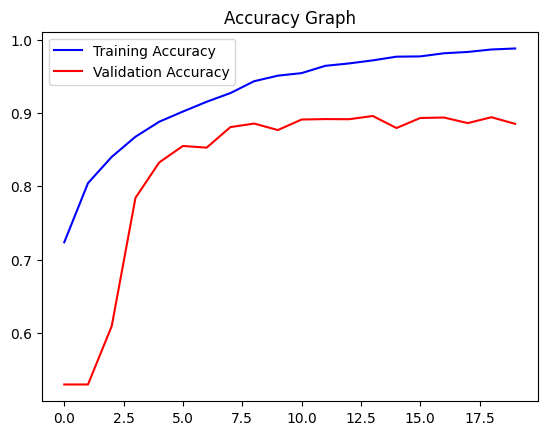

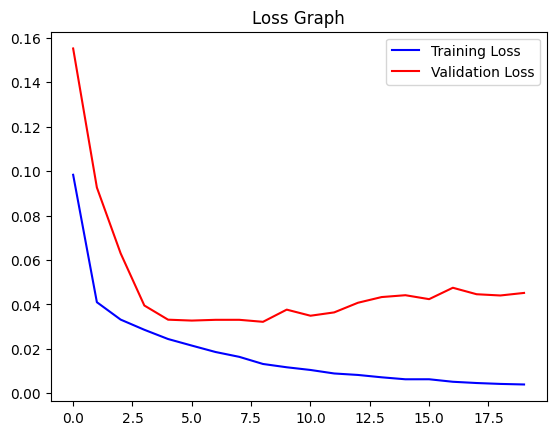

In [ ]:
# ... (previous code) ...

# Assuming X and y_gender, y_age are your training data
history = model.fit(X, [y_gender, y_age],
                    validation_split=0.2,
                    epochs=20,
                    batch_size=128)

acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

# ... (rest of the code) ...

acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


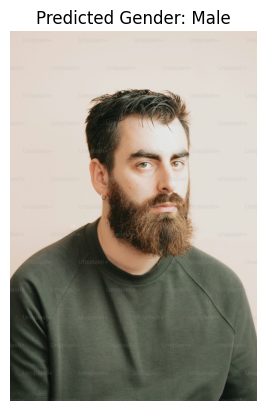

[array([[0.17183365]], dtype=float32), array([[75.3114]], dtype=float32)]


In [ ]:
from tensorflow.keras.utils import load_img # This imports load_img
#from keras.preprocessing import image # Remove or comment this line
# ... (rest of your code) ...

def get_image_features(image):
  img = load_img(image, color_mode='grayscale') # Change grayscale to color_mode='grayscale'
  img = img.resize((128, 128), Image.LANCZOS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

img_to_test = '/content/drive/MyDrive/risi.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]

# Open the image using PIL.Image.open
img = Image.open(img_to_test)

plt.title(f'Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(img)) # Display the image using PIL and np.array
plt.show() # Add plt.show() to display the plot
print(pred)

<IPython.core.display.Javascript object>

Saved to photo.jpg


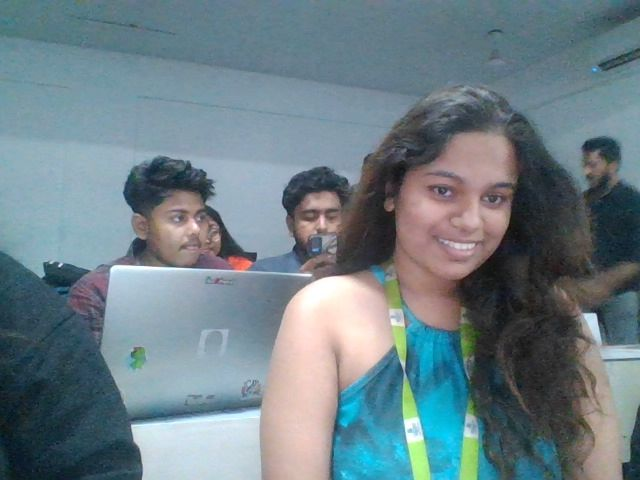

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


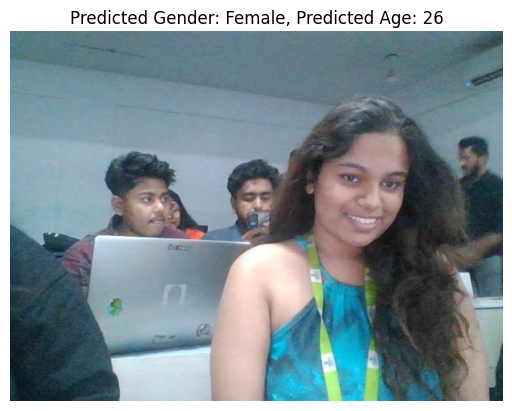

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to take a photo
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Function to extract features from the captured image
def get_image_features(image):
  img = Image.open(image).convert('L') # Convert to grayscale
  img = img.resize((128, 128), Image.LANCZOS) # Resize to the model's input size
  img = np.array(img) # Convert to NumPy array
  img = img.reshape(1, 128, 128, 1) # Reshape to match the model's input shape
  img = img / 255.0 # Normalize pixel values
  return img

# Take a photo and display it
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image.open(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Extract features from the captured image and make a prediction
features = get_image_features(filename)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

# Display the prediction
plt.title(f'Predicted Gender: {gender}, Predicted Age: {age}')
plt.axis('off')
plt.imshow(np.array(Image.open(filename)))
plt.show()